# Ejercicio 4 - Consigna
Descargar el dataset del siguiente link: https://drive.google.com/file/d/1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd/view?usp=sharing. El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizar el dataset para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro. Particularmente, vamos a tratar este problema como una clasificación binaria donde queremos averiguar si el cliente va a gastar mucha plata (más de 9000) o poca plata (menos de 9000).

- a)	Entrenar un modelo de deep learning que no utilice embeddings.
- b)	Entrenar un modelo de deep learning que utilice embeddings tanto para los productos como los usuarios. Realizar el mapeo de identificador de producto y usuarios a indices antes de separar el dataset en training, validation y testing.
- c)	Compare el score de cada modelo y comente lo necesario.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (a)

## Cargamos el dataset

In [62]:
df = pd.read_csv("dataset_black_sales.csv")

## Analisis exploratorio

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [64]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [65]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

Valores Nulos encontrados para las categorías secundarias y terciarias. Dado que no tenemos más información sobre a qué referencia hacen, las pondremos en 0 ya que actualmente no se utiliza ese valor (ver siguientes secciones).

In [66]:
df.fillna(0,inplace=True)  # reemplazamos los N/A por 0

In [67]:
# Veamos la cantidad de valores únicos de algunos otros features
for i in ['User_ID', 'Product_ID']:
    print(i + ' unique values: ' + str(len(df[i].unique())))
# Veamos los valores unicos de algunos de los features
for i in ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']:
    print(i + ' values: ' + str(df[i].unique()) + ' - Total: ' + str(len(df[i].unique())))


User_ID unique values: 5891
Product_ID unique values: 3631
Gender values: ['F' 'M'] - Total: 2
Age values: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25'] - Total: 7
Occupation values: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6] - Total: 21
City_Category values: ['A' 'C' 'B'] - Total: 3
Stay_In_Current_City_Years values: ['2' '4+' '3' '1' '0'] - Total: 5
Marital_Status values: [0 1] - Total: 2
Product_Category_1 values: [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19] - Total: 20
Product_Category_2 values: [ 0.  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.] - Total: 18
Product_Category_3 values: [ 0. 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.] - Total: 16


Text(721.8320000000001, 0.5, 'Product_Category_3')

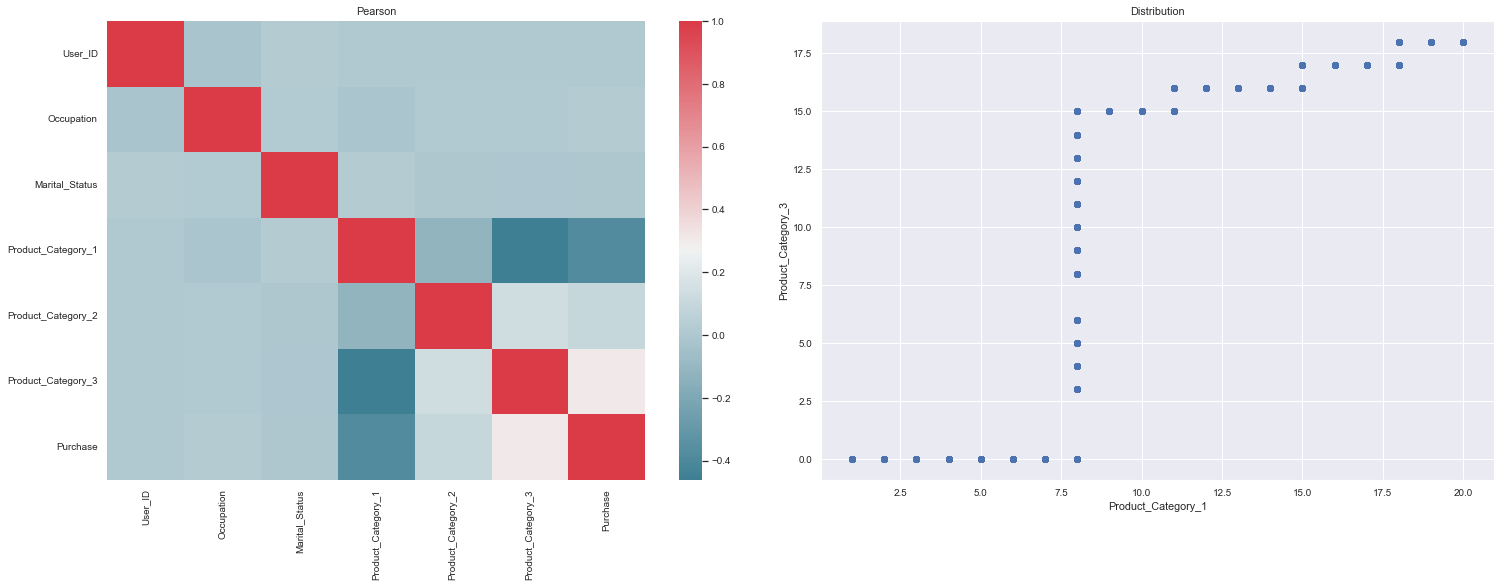

In [68]:
import seaborn as sns

corr_spearman = df.corr(method='spearman')

fig, axes = plt.subplots(1,2,figsize=(20,7), )
plt.tight_layout()

axes[0].set_title("Pearson")
sns.heatmap(corr_spearman, cmap=sns.diverging_palette(220,10,as_cmap=True),fmt=".2f",ax=axes[0])
sns.set(font_scale=0.9)

axes[1].set_title("Distribution")
plt.scatter(np.sort(df['Product_Category_1']), np.sort(df['Product_Category_3']))
plt.xlabel('Product_Category_1')
plt.ylabel('Product_Category_3')

Correlación: el análisis de correlación de Spearman no muestra una gran correlación entre los features. La mayor correlación se da entre las categorías 1 y 3, llegando a ser de 0.5. Sin embargo, un análisis de las distribuciones de una contra la otra muestra que la categoría 3 nos aporta gran cantidad de información que la 1 no tiene (notar alrededor del 8 de categoría 1). Por lo tanto , no podemos reducir dimensionalidad sin perder información significativa que puede ser útil para el problema final.

In [69]:
# Veamos la relación de otras variables con la salida
# plt.figure(figsize=(12,12))
# df.plot(x='Age', y='Purchase', figsize=(12,12))
df['y'] = df['Purchase'] >= 9000
# df.hist(column='Purchase', by='Age', figsize=(12,12))
df.groupby('y').nunique()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
y,,,,,,,,,,,,
False,5890,3559,2,7,21,3,5,2,20,18,16,7304
True,5874,2031,2,7,21,3,5,2,12,17,16,10801


### Analizamos las variables categóricas respecto a la variable de salida

#### Stay_In_Current_City_Years

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

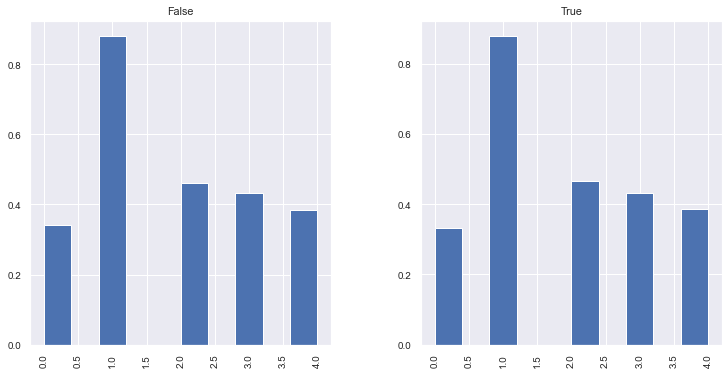

In [130]:
df_temp = df.copy()
df_temp['Stay_In_Current_City_Years'].replace(['2', '4+', '3', '1', '0'], [2, 4, 3, 1, 0], inplace=True)
df_temp.hist(column='Stay_In_Current_City_Years', by='y', figsize=(12,6), density=1, sharex=True) # density=1 para normalizar entre ambos histogramas (ya sabemos que va a haber menos gente que compra > 9000)

# Del gráfico se puede ver que la distribución es prácticamente la misma para y=0 e y=1, por lo que esta variable no nos aporta tanta información

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


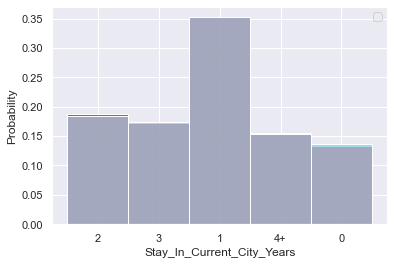

In [169]:
sns.set(style="darkgrid")
sns.histplot(data=df[df['y']==True], x="Stay_In_Current_City_Years", color="red", label="Sepal Width",  stat = "probability")
sns.histplot(data=df[df['y']==False], x="Stay_In_Current_City_Years", color="skyblue", label="Sepal Length",  stat = "probability")
plt.legend() 
plt.show()

#### City_Category

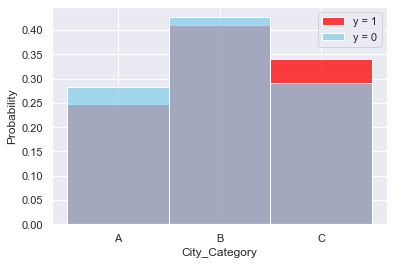

In [181]:
sns.set(style="darkgrid")
sns.histplot(data=df[df['y']==True], x="City_Category", color="red", label="y = 1",  stat = "probability")
sns.histplot(data=df[df['y']==False], x="City_Category", color="skyblue", label="y = 0",  stat = "probability")
plt.legend() 
plt.show()
# La categoría de la ciudad sí influye en la salida

#### Marital_Status

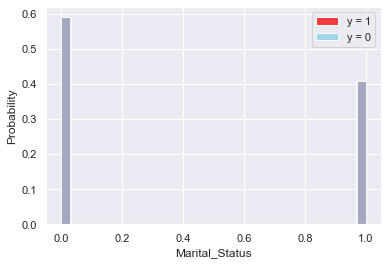

In [182]:
# df.hist(column='', by='y', density=1)
sns.set(style="darkgrid")
sns.histplot(data=df[df['y']==True], x="Marital_Status", color="red", label="y = 1",  stat = "probability")
sns.histplot(data=df[df['y']==False], x="Marital_Status", color="skyblue", label="y = 0",  stat = "probability")
plt.legend() 
plt.show()

# El estado civil no afecta en la salida

#### Occupation

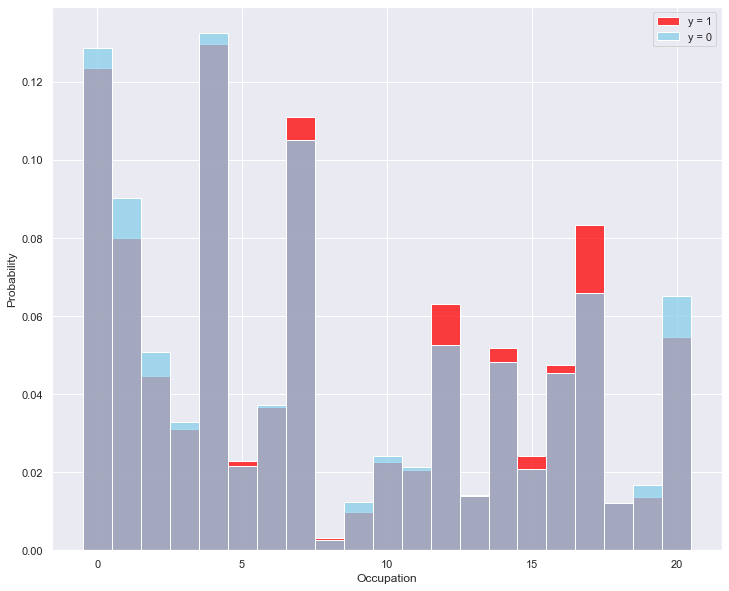

In [210]:
sns.set(style="darkgrid")
plt.figure(figsize=(12,10))
sns.histplot(data=df[df['y']==True], x="Occupation", color="red", label="y = 1",  stat = "probability", discrete=True)
sns.histplot(data=df[df['y']==False], x="Occupation", color="skyblue", label="y = 0",  stat = "probability", discrete=True)
plt.legend() 
plt.show()
# Para la ocupación, se empieza a ver impacto en la salida. Se nota que, para las ocupaciones menos frecuentes (menos muestras), no existe tanta 
# diferencia a la hora de predecir la variable de salida. Esto nos permite agrupar las N categorias con menor frecuencia en una sola, 
# ahorrando dimensiones finales.

# Occupation values: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6] - Total: 21
# df_temp['Occupation'] = df_temp['Occupation'].apply(lambda x: 0 if x<7 else (1 if x < 14 else 2))

#### Age

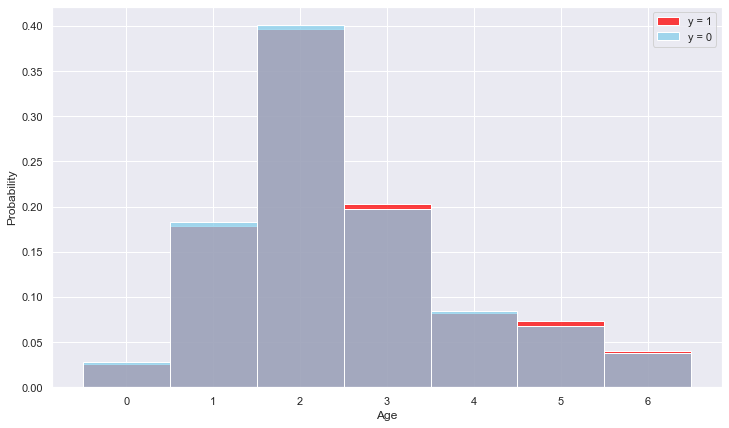

<Figure size 360x360 with 0 Axes>

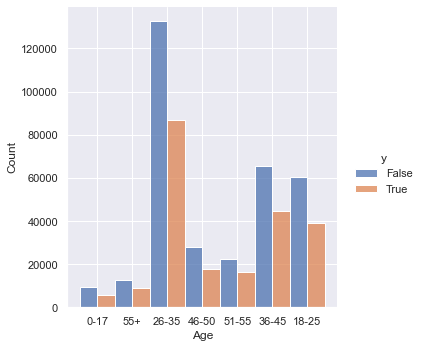

In [218]:
# Age values: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25'] - Total: 7
df_temp = df.copy()
# df_temp['Age'].replace(['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25'], [0, 55, 26, 46, 51, 36, 18], inplace=True)
df_temp['Age'].replace(['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25'], [0, 6, 2, 4, 5, 3, 1], inplace=True)
plt.figure(figsize=(12,7))
sns.set(style="darkgrid")
sns.histplot(data=df_temp[df_temp['y']==True], x="Age", color="red", label="y = 1",  stat = "probability", discrete=True)
sns.histplot(data=df_temp[df_temp['y']==False], x="Age", color="skyblue", label="y = 0",  stat = "probability", discrete=True)
plt.legend() 
plt.figure(figsize=(5,5))
df_temp = df.copy()
sns.displot(df, x="Age", hue="y", multiple="dodge")
# Se ve una leve tendencia de las mayores edades a hacer compras grandes

#### Gender

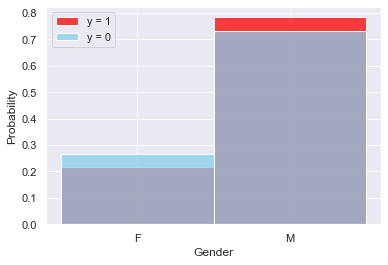

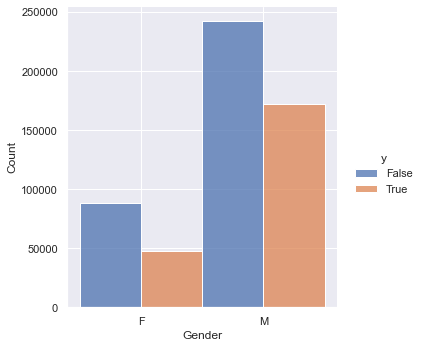

In [223]:
sns.set(style="darkgrid")
sns.histplot(data=df[df['y']==True], x="Gender", color="red", label="y = 1",  stat = "probability")
sns.histplot(data=df[df['y']==False], x="Gender", color="skyblue", label="y = 0",  stat = "probability")
plt.legend() 
plt.show()
sns.displot(df, x="Gender", hue="y", multiple="dodge")
# El gender nos da cierta información. Los hombres son más probables a hacer la compra más cara.

## Reducción de dimensionalidad y Codificación
Según las conclusiones obtenidas en la exploración del dataset, y dado que en este punto de la consigna no se deben utilizar embeddings, procedemos a quitar las variables categóricas que tienen menor correlación con la variable de salida, ya que incluirlas durante el entrenamiento incurriría en un aumento significativo del dataset al hacer One-Hot Encoding o similar.

Dado que no vamos a usar embeddings, el User_ID y el Product_ID son variables categóricas que se hace dificl codificar sin aumentar en gran cantidad las dimensiones.

In [238]:
dfa = df.copy()
dfa = dfa.drop(['User_ID', 'Product_ID', 'Product_Category_2', 'Product_Category_3', 'Marital_Status', 'Stay_In_Current_City_Years', 'Purchase'], axis=1)
dfa.head()

,Gender,Age,Occupation,City_Category,Product_Category_1,y
0,F,0-17,10,A,3,False
1,F,0-17,10,A,1,True
2,F,0-17,10,A,12,False
3,F,0-17,10,A,12,False
4,M,55+,16,C,8,False


In [239]:
# Gender lo codificamos binario
dfa['Gender'] = dfa['Gender'].apply(lambda x: 1 if x == 'M' else 0)

# Age con One-hot encoding
age_dummies = pd.get_dummies(dfa['Age'], prefix="age")
dfa = pd.concat([dfa,age_dummies], axis = 1)
dfa = dfa.drop(['Age'], axis=1)
dfa.head()

# Asumimos que Occupation ya fue codificado con Integer encoding (ya que no tenemos datos de cómo se asignaron números a las categorías).
# Sin embargo, 

,Gender,Occupation,City_Category,Product_Category_1,y,age_0-17,age_18-25,age_26-35,age_36-45,age_46-50,age_51-55,age_55+
0,0,10,A,3,False,1,0,0,0,0,0,0
1,0,10,A,1,True,1,0,0,0,0,0,0
2,0,10,A,12,False,1,0,0,0,0,0,0
3,0,10,A,12,False,1,0,0,0,0,0,0
4,1,16,C,8,False,0,0,0,0,0,0,1


In [7]:
# Type es tipo categórica, transformamos con One Hot Encoding
type_dummies = pd.get_dummies(df['type'], prefix="type")
type_dummies

,type_red,type_white
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
6492,1,0
6493,1,0
6494,1,0
6495,1,0


In [8]:
df = pd.concat([df,type_dummies], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6497 non-null   int64  
 1   type                  6497 non-null   object 
 2   fixed acidity         6487 non-null   float64
 3   volatile acidity      6489 non-null   float64
 4   citric acid           6494 non-null   float64
 5   residual sugar        6495 non-null   float64
 6   chlorides             6495 non-null   float64
 7   free sulfur dioxide   6497 non-null   float64
 8   total sulfur dioxide  6497 non-null   float64
 9   density               6497 non-null   float64
 10  pH                    6488 non-null   float64
 11  sulphates             6493 non-null   float64
 12  alcohol               6497 non-null   float64
 13  quality               6497 non-null   int64  
 14  vendor_id             6497 non-null   int64  
 15  type_red             

In [9]:
# Exploramos vendor_id
len(df['vendor_id'].unique())

500

vendor_id es tipo categórica con gran cantidad de valores diferentes, no podemos aplicar One Hot Encoding. Por el momento se descarta, en un futuro utilizaremos capas de embeddings con esta variable.

In [10]:
# Mi variable a predecir es quality, la calidad del vino.
df['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9])

(array([  30.,  216.,    0., 2138.,    0., 2836., 1079.,    0.,  193.,
           5.]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <a list of 10 Patch objects>)

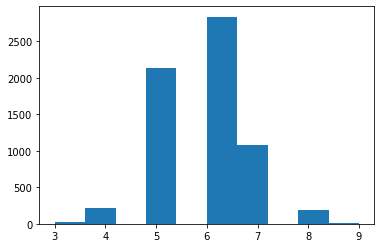

In [11]:
quality = df['quality'].to_numpy()
fig, ax1 = plt.subplots(1,1)
ax1.hist(quality)

Por simplicidad convertimos el problema en un problema de clasificación binaria: 0 si el vino es "malo", 1 si el vino es "bueno"

In [12]:
df["quality_label"] = df["quality"].apply(lambda q:0 if q<=6 else 1)

In [13]:
df.sample(7)

,Unnamed: 0,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,vendor_id,type_red,type_white,quality_label
3952,3952,white,7.0,0.16,0.30,2.6,0.043,34.0,90.0,0.99047,2.88,0.47,11.2,6,326,0,1,0
3678,3678,white,7.2,0.23,0.25,18.8,0.085,19.0,111.0,1.00044,3.10,0.51,8.7,5,208,0,1,0
859,859,white,6.6,0.30,0.30,4.8,0.170,60.0,166.0,0.99460,3.18,0.47,9.4,5,232,0,1,0
189,189,white,6.5,0.28,0.28,8.5,0.047,54.0,210.0,0.99620,3.09,0.54,8.9,4,180,0,1,0
3182,3182,white,5.5,0.12,0.33,1.0,0.038,23.0,131.0,0.99164,3.25,0.45,9.8,5,292,0,1,0
5229,5229,red,10.2,0.36,0.64,2.9,0.122,10.0,41.0,0.99800,3.23,0.66,12.5,6,303,1,0,0
4148,4148,white,6.2,0.20,0.25,15.0,0.055,8.0,120.0,0.99767,3.19,0.53,9.6,6,308,0,1,0


In [14]:
# Comprobamos la existencia de nan
df.isna().sum(axis=0)

Unnamed: 0               0
type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
vendor_id                0
type_red                 0
type_white               0
quality_label            0
dtype: int64

In [15]:
# Como tenemos pocos nan, borramos las filas donde hay nan y trabajamos con un dataset completo
ds = df[df.isna().sum(axis = 1) == 0]

In [16]:
ds.isna().sum()

Unnamed: 0              0
type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
vendor_id               0
type_red                0
type_white              0
quality_label           0
dtype: int64

## Armado del dataset

In [17]:
# Guardo vendor_id para un futuro modelo con embeddings
vendor_id = ds['vendor_id']
# Recordar que debo borrar del dataset de entrada mi columna de salida!
x = ds.drop(['Unnamed: 0','type','vendor_id','quality','quality_label'], axis=1) 
y = ds['quality_label']

In [18]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6463 non-null   float64
 1   volatile acidity      6463 non-null   float64
 2   citric acid           6463 non-null   float64
 3   residual sugar        6463 non-null   float64
 4   chlorides             6463 non-null   float64
 5   free sulfur dioxide   6463 non-null   float64
 6   total sulfur dioxide  6463 non-null   float64
 7   density               6463 non-null   float64
 8   pH                    6463 non-null   float64
 9   sulphates             6463 non-null   float64
 10  alcohol               6463 non-null   float64
 11  type_red              6463 non-null   uint8  
 12  type_white            6463 non-null   uint8  
dtypes: float64(11), uint8(2)
memory usage: 618.5 KB


In [19]:
y

0       0
1       0
2       0
3       0
4       0
       ..
6491    0
6492    0
6494    0
6495    0
6496    0
Name: quality_label, Length: 6463, dtype: int64

## Normalizacion

Las redes neuronales no requieren que los datos esten normalizados, pero la normalización ayuda a que el algoritmo de gradient descent converga más rápido.

In [20]:
x = x.to_numpy()
y = y.to_numpy()

In [21]:
x

array([[ 7.   ,  0.27 ,  0.36 , ...,  8.8  ,  0.   ,  1.   ],
       [ 6.3  ,  0.3  ,  0.34 , ...,  9.5  ,  0.   ,  1.   ],
       [ 8.1  ,  0.28 ,  0.4  , ..., 10.1  ,  0.   ,  1.   ],
       ...,
       [ 6.3  ,  0.51 ,  0.13 , ..., 11.   ,  1.   ,  0.   ],
       [ 5.9  ,  0.645,  0.12 , ..., 10.2  ,  1.   ,  0.   ],
       [ 6.   ,  0.31 ,  0.47 , ..., 11.   ,  1.   ,  0.   ]])

In [22]:
np.min(x, axis=0)

array([3.8    , 0.08   , 0.     , 0.6    , 0.009  , 1.     , 6.     ,
       0.98711, 2.72   , 0.22   , 8.     , 0.     , 0.     ])

In [23]:
# Normalización min max
x_norm = (x - np.min(x, axis=0)) / (np.max(x, axis=0 ) - np.min(x, axis=0))

In [24]:
print(np.min(x_norm, axis=0))
print(np.max(x_norm, axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## División del dataset
Divido en entrenamiento y validación

In [25]:
idx = np.random.permutation(x_norm.shape[0])
idx

array([5884,  405, 5556, ..., 5788, 5800, 6167])

In [26]:
train_idx = idx[0:int(0.85*len(idx))]
valid_idx = idx[int(0.85*len(idx)):]
print(train_idx.shape)
print(valid_idx.shape)

(5493,)
(970,)


In [27]:
train_x = x_norm[train_idx]
train_y = y[train_idx]
valid_x = x_norm[valid_idx]
valid_y = y[valid_idx]

n_train = train_x.shape[0]
n_valid = valid_x.shape[0]

## Pytorch

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [29]:
# Pytorch necesita de una clase de dataset que extienda de torch.utils.data.Dataset
# Esta clase dataset debe sobreescribir los métodos init, len y getitem
class MyDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = x
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.x.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [30]:
# Creo el dataset de entrenamiento
train_ds = MyDataset(train_x, train_y)

In [31]:
# Testeo funcionamiento de __getitem__
train_ds[20]

(array([0.17355372, 0.23666667, 0.09638554, 0.08895706, 0.03654485,
        0.06944444, 0.29493088, 0.08482745, 0.40310078, 0.13483146,
        0.60869565, 0.        , 1.        ]), 0)

In [32]:
# Creo el dataset de validación
valid_ds = MyDataset(valid_x, valid_y)

In [33]:
# Testeo funcionamiento de __len__
len(valid_ds)

970

In [34]:
# Pytorch utiliza DataLoader para entregar los dataset de a batches
train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle= True)
valid_dataloader = DataLoader(valid_ds, batch_size=64)

In [35]:
# Test dataloader
batch_1 = next(iter(train_dataloader))
batch_1[1].shape

torch.Size([64])

In [36]:
print(type(batch_1[0]))

<class 'torch.Tensor'>


### Tensores
Los objetos torch.Tensor son vectores muy parecidos a los vectores de numpy pero pueden ejecutar funciones en GPU (numpy solo corre en CPU) y pueden guardar información del grafo de cómputos para realizar luego el backpropagation

In [37]:
# Defino 2 tensores con seguimiento del grafo de cómputos
w = torch.tensor([1.0], requires_grad=True)
q = torch.tensor([5.0], requires_grad=True)
print(w)
print(q)

tensor([1.], requires_grad=True)
tensor([5.], requires_grad=True)


In [38]:
# Defino z y p como cálculos sobre w y q
z = w * q 
p = z**2

In [39]:
# z y p almacenen información de como fueron cálculados para facilitar el backpropagation
print(z)
print(p)

tensor([5.], grad_fn=<MulBackward0>)
tensor([25.], grad_fn=<PowBackward0>)


In [40]:
# Ejecutamos el cálculo del backpropagation
p.backward()

In [41]:
# w y q poseen en grad el cálculo del dp/dw y dp/dz respectivamente
print(w.grad)
print(q.grad)

tensor([50.])
tensor([10.])


### Arquitectura NNet Pytorch
La red neuronal en Pytorch se define extendiendo torch.nn.Module

In [42]:
class NNet(torch.nn.Module):

  def __init__(self):
    # Defino la arquitectura de la red
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=13, out_features=200, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features = 200, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features = 100, out_features= 1, bias=True)

  def forward(self, x):
    # Defino el cálculo del paso forward
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.output(x)
    return x

In [43]:
# Instanciamos la red
nnet = NNet()

In [44]:
print(nnet)

NNet(
  (linear_1): Linear(in_features=13, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=100, bias=True)
  (relu_2): ReLU()
  (output): Linear(in_features=100, out_features=1, bias=True)
)


In [45]:
# Imprimimos los parámetros optimizables de la red
print([p for p in nnet.parameters()])

[Parameter containing:
tensor([[ 0.1896,  0.1583,  0.0041,  ..., -0.1601,  0.1996, -0.0217],
        [ 0.2530, -0.0420,  0.0492,  ..., -0.2264, -0.2078,  0.1821],
        [ 0.1809,  0.0487, -0.2173,  ...,  0.0866,  0.0461, -0.0011],
        ...,
        [-0.1602,  0.0437, -0.0569,  ...,  0.0164,  0.1584,  0.1844],
        [-0.1635, -0.2118,  0.0296,  ..., -0.1963, -0.0106,  0.1936],
        [-0.2279, -0.0059, -0.1513,  ..., -0.1411,  0.1050,  0.1379]],
       requires_grad=True), Parameter containing:
tensor([ 0.2530, -0.2613,  0.0945,  0.2165, -0.1833, -0.0903, -0.1350, -0.0996,
         0.2623, -0.2207, -0.0649,  0.1594,  0.1566,  0.1588,  0.0787, -0.2267,
        -0.1646, -0.1894, -0.1136, -0.0121, -0.1304, -0.0592, -0.1330,  0.0070,
         0.0682,  0.1506, -0.1436,  0.1322, -0.1771,  0.1771,  0.1749, -0.0089,
        -0.1078,  0.0609,  0.0110, -0.0656,  0.2594, -0.0937,  0.0523,  0.0753,
         0.1967,  0.2412,  0.2519,  0.0022,  0.0246,  0.2104,  0.2088, -0.2626,
         0.09

In [46]:
# Imprimo la cantidad de parámetros optimizables de la red
print(sum(p.numel() for p in nnet.parameters()))

23001


### Loss y optimizador
- Como loss function utilizo BCE por ser un problema de clasificación binaria.

**Nota**: la función sigmoid de salida no se definió en la arquitectura de la red neuronal porque utilizo BCEWithLogitsLoss que combina sigmoid+BCE. Hago esto para tener mejor estabilidad numérica: [link](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

Podría utilizar BCELoss y agregar la capa sigmoid en la clase NNet

- Como optimizador utilizo Adam

In [47]:
loss_function = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.01)

Pytorch puede correr en GPU. Con el siguiente código chequeo si hay una GPU compatible disponible y la utilizo en ese caso.

**Como utilizar GPU con colab**: Ir a Entorno de ejecucion -> Cambiar tipo de entorno de ejecución. Seleccionar GPU

In [48]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

'cuda:0'

In [49]:
# Copio la red neuronal al dispositivo donde entrene la red neuronal
nnet = nnet.to(device)

### Entrenamiento y validación red neuronal

Entreno con algoritmo Mini-Batch

In [50]:
# cantidad de epochs
epochs = 100

train_loss_by_epoch=[]
valid_loss_by_epoch=[]

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):
  
  ############################################
  ## Entrenamiento
  ############################################
  nnet.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []
  
  for i,data in enumerate(train_dataloader):
    # Obtengo los datos del batch de entrenamiento
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    nnet_output = nnet(x_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / n_train
  # Almaceno la loss de la epoch para graficar
  train_loss_by_epoch.append(epoch_loss)
  # Cálculo la métrica de la epoch
  accuracy = metrics.accuracy_score(epoch_y, [j>=0.5 for j in epoch_y_hat])

  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnet.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(valid_dataloader):
    # Obtengo los datos del batch de validación
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    nnet_output = nnet(x_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / n_valid
  # Almaceno la loss de la epoch para graficar
  valid_loss_by_epoch.append(valid_epoch_loss)
  # Cálculo la métrica de la epoch
  valid_accuracy = metrics.accuracy_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid accuracy: {accuracy:.3f} / {valid_accuracy:.3f}")

 Epoch 0 | Train/Valid loss: 0.430 / 0.416 | Train/Valid accuracy: 0.803 / 0.823
 Epoch 1 | Train/Valid loss: 0.402 / 0.419 | Train/Valid accuracy: 0.815 / 0.809
 Epoch 2 | Train/Valid loss: 0.396 / 0.426 | Train/Valid accuracy: 0.816 / 0.811
 Epoch 3 | Train/Valid loss: 0.396 / 0.403 | Train/Valid accuracy: 0.818 / 0.816
 Epoch 4 | Train/Valid loss: 0.383 / 0.403 | Train/Valid accuracy: 0.817 / 0.821
 Epoch 5 | Train/Valid loss: 0.386 / 0.395 | Train/Valid accuracy: 0.820 / 0.806
 Epoch 6 | Train/Valid loss: 0.377 / 0.385 | Train/Valid accuracy: 0.823 / 0.819
 Epoch 7 | Train/Valid loss: 0.374 / 0.394 | Train/Valid accuracy: 0.823 / 0.818
 Epoch 8 | Train/Valid loss: 0.374 / 0.391 | Train/Valid accuracy: 0.827 / 0.825
 Epoch 9 | Train/Valid loss: 0.371 / 0.375 | Train/Valid accuracy: 0.821 / 0.828
 Epoch 10 | Train/Valid loss: 0.365 / 0.387 | Train/Valid accuracy: 0.828 / 0.814
 Epoch 11 | Train/Valid loss: 0.372 / 0.393 | Train/Valid accuracy: 0.825 / 0.820
 Epoch 12 | Train/Valid lo

Text(0, 0.5, 'BCE')

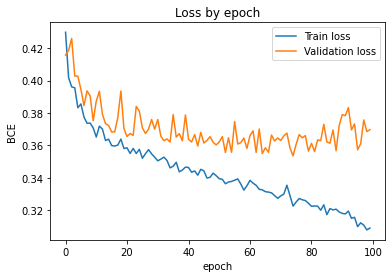

In [52]:
fig, ax1= plt.subplots(1,1)
ax1.plot(train_loss_by_epoch, label="Train loss")
ax1.plot(valid_loss_by_epoch, label="Validation loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("epoch")
ax1.set_ylabel("BCE")